## AirBnB dataset preprocessing

Here I include some preprocessing that is neccesary before we pass the data to the wide and deep model

In [20]:
import numpy as np
import pandas as pd
import warnings

from pathlib import Path

warnings.filterwarnings('ignore')

DATA_PATH = Path('../data/airbnb')
df_original = pd.read_csv(DATA_PATH/'listings.csv')
print(df_original.shape)
df_original.head()

(79129, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190307140352,2019-03-08,Holiday London DB Room Let-on going,My bright double bedroom with a large window has a relaxed feeling! It comfortably fits one or t...,"Hello Everyone, I'm offering my lovely double bedroom in Finsbury Park area (zone 2) for let in ...",My bright double bedroom with a large window has a relaxed feeling! It comfortably fits one or t...,business,"Finsbury Park is a friendly melting pot community composed of Turkish, French, Spanish, Middle E...",For art lovers I can give guest my Tate Members card to which offers free access to the both the...,The flat only a 10 minute walk to Finsbury Park Station (London Zone 2) with access to the Picca...,Guest will have access to the self catering kitchen and bathroom. There is the flat is equipped ...,I like to have little chats with my guest over a cup of coffee or tea or even a drink in our loc...,I'm an artist and have my artwork up on the wall so please care. When existing: You must lock a...,NaN,NaN,https://a0.muscache.com/im/pictures/985879/b0680c62_original.jpg?aki_policy=large,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative Practitioner in Education. I live in London Engla...,within a day,60%,NaN,f,https://a0.muscache.com/im/users/54730/profile_pic/1327774386/original.jpg?aki_policy=profile_small,https://a0.muscache.com/im/users/54730/profile_pic/1327774386/original.jpg?aki_policy=profile_x_...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Islington, Greater London, United Kingdom",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,...,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off premises"",""Smoking allowed"",""Free street parking"",...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,3 months ago,t,30,60,89,363,2019-03-08,14,3,2010-08-18,2018-06-17,95.0,9.0,10.0,9.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,3,1,2,0,0.13
1,15400,https://www.airbnb.com/rooms/15400,20190307140352,2019-03-08,Bright Chelsea Apartment. Chelsea!,"Lots of windows and light. St Luke's Gardens are at the end of the block, and the river not too...",Bright

Our goal will be to predict the so called "yield" value of the property, a meassure of how profitable the property might be. To that aim, we should only keep features that are known by at the time that an owner registers the property at Airbnb plus, of course, those required to estimate "yield" (price and number of reviews per month). For example, review scores should not be included while description or house rules can perfectly be part of our dataset.

In [21]:
keep_cols = ['id', 'host_id', 'description', 'house_rules', 'host_name',
    'host_listings_count', 'host_identity_verified', 'neighbourhood_cleansed',
    'latitude', 'longitude','is_location_exact','property_type', 'room_type',
    'accommodates', 'bathrooms', 'bedrooms','beds', 'amenities', 'price',
    'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 
    'minimum_nights','instant_bookable','cancellation_policy', 
    'reviews_per_month']

In [22]:
df = df_original[keep_cols]
df = df[~df.reviews_per_month.isna()]
df = df[~df.description.isna() ]
df = df[~df.host_listings_count.isna()]
print(df.shape)

(58567, 27)


## House rules

I will simply include a binary column with 1/0 if the property has/has not house rules.

In [23]:
df['has_house_rules'] = df['house_rules']
df.has_house_rules.fillna(0, inplace=True)
df['has_house_rules'][df.has_house_rules!=0] = 1
df.drop('house_rules', axis=1, inplace=True)

## Host name

I will use names to infer gender using `gender_guesser`

In [24]:
import gender_guesser.detector as gender
from collections import Counter

host_name = df.host_name.tolist()
d = gender.Detector()
host_gender = [d.get_gender(n) for n in host_name]
replace_dict = {'mostly_male': 'male', 'mostly_female': 'female', 'andy': 'unknown'}
host_gender = [replace_dict.get(item,item) for item in host_gender]
Counter(host_gender)

Counter({'female': 23998, 'male': 21008, 'unknown': 13561})

In [25]:
df['host_gender'] = host_gender
df.drop('host_name', axis=1, inplace=True)

### Property type, room type, accommodates, bathrooms, bedrooms, beds and guests included, host listings count, minimum nights

Here some standard pre-processing...

In [26]:
df.property_type.value_counts()
replace_prop_type = [val for val in df.property_type.unique().tolist() if val not in ['Apartment', 'House']]
replace_prop_type = {k:'other' for k in replace_prop_type}
df.property_type.replace(replace_prop_type, inplace=True)
df['property_type'] = df.property_type.apply(lambda x: '_'.join(x.split(' ')).lower())

In [27]:
df.room_type.value_counts()
df['room_type'] = df.room_type.apply(lambda x: '_'.join(x.split(' ')).lower())

In [28]:
df['bathrooms'][(df.bathrooms.isna()) & (df.room_type == 'private_room')] = 0
df['bathrooms'][(df.bathrooms.isna()) & (df.room_type == 'entire_home/apt')] = 1
df.bedrooms.fillna(1, inplace=True)
df.beds.fillna(1, inplace=True)

In [29]:
# Encode some as categorical
categorical_cut = [('accommodates', 3),
    ('guests_included', 3),
    ('minimum_nights', 3),
    ('host_listings_count', 3),
    ('bathrooms', 1.5),
    ('bedrooms', 3),
    ('beds', 3)
    ]

for col, cut in categorical_cut:
    new_colname = col + '_catg'
    df[new_colname] = df[col].apply(lambda x: cut if x >=cut else x)
    df[new_colname] = df[new_colname].round().astype(int)

## Amenities

I will just add a number of dummy columns with 1/0 if the property has/has not that particular amenity

In [30]:
from functools import reduce
from itertools import chain

amenity_repls = (("\"", ""), ("{", ""), ("}", ""),(" / ", "_"), ("/", "_"), (" ", "_"), ("(s)", ""))

amenities_raw = df.amenities.str.lower().tolist()
amenities = [reduce(lambda a, kv: a.replace(*kv), amenity_repls, s).split(",") for s in amenities_raw]

all_amenities = list(chain(*amenities))
all_amenities_count = Counter(all_amenities)
all_amenities_count

Counter({'tv': 41218,
         'cable_tv': 10578,
         'wifi': 56843,
         'kitchen': 53991,
         'paid_parking_off_premises': 10706,
         'smoking_allowed': 4194,
         'free_street_parking': 5904,
         'buzzer_wireless_intercom': 9114,
         'heating': 55891,
         'family_kid_friendly': 22489,
         'washer': 50509,
         'dryer': 26663,
         'smoke_detector': 51264,
         'carbon_monoxide_detector': 34426,
         'fire_extinguisher': 18943,
         'essentials': 55732,
         'shampoo': 41965,
         'lock_on_bedroom_door': 13230,
         'hangers': 47943,
         'hair_dryer': 43255,
         'iron': 45991,
         'laptop_friendly_workspace': 39002,
         'outlet_covers': 265,
         'bathtub': 5267,
         'children’s_books_and_toys': 2873,
         'babysitter_recommendations': 1225,
         'crib': 2726,
         'pack_’n_play_travel_crib': 2728,
         'room-darkening_shades': 2087,
         'children’s_dinnerware'

In [31]:
# having a look to the list we see that one amenity is empty and two are
# "translation missing:..."
keep_amenities = []
for k,v in all_amenities_count.items():
    if k and 'missing' not in k:
        keep_amenities.append(k)

final_amenities = [[amenity for amenity in house_amenities if amenity in keep_amenities]
    for house_amenities in amenities]

# some properties have no amenities aparently
final_amenities = [['no amenities'] if not amenity else amenity for amenity in final_amenities]
final_amenities = [['amenity_'+ amenity for amenity in amenities] for amenities in final_amenities]

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer

df_list_of_amenities = pd.DataFrame(
    {'groups': final_amenities
    }, columns=['groups'])
df_list_of_amenities.head()

,groups
0,"[amenity_tv, amenity_cable_tv, amenity_wifi, amenity_kitchen, amenity_paid_parking_off_premises,..."
1,"[amenity_tv, amenity_cable_tv, amenity_internet, amenity_wifi, amenity_air_conditioning, amenity..."
2,"[amenity_tv, amenity_wifi, amenity_kitchen, amenity_paid_parking_off_premises, amenity_elevator,..."
3,"[amenity_tv, amenity_cable_tv, amenity_internet, amenity_wifi, amenity_kitchen, amenity_free_par..."
4,"[amenity_tv, amenity_wifi, amenity_kitchen, amenity_free_parking_on_premises, amenity_elevator, ..."


In [33]:
df_list_of_amenities = pd.DataFrame(
    {'groups': final_amenities
    }, columns=['groups'])
s = df_list_of_amenities['groups']
mlb = MultiLabelBinarizer()
df_amenities = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=df.index)

In [34]:
df_amenities.head()

,amenity_24-hour_check-in,amenity__toilet,amenity_accessible-height_bed,amenity_accessible-height_toilet,amenity_air_conditioning,amenity_air_purifier,amenity_alfresco_bathtub,amenity_amazon_echo,amenity_baby_bath,amenity_baby_monitor,amenity_babysitter_recommendations,amenity_balcony,amenity_bath_towel,amenity_bathroom_essentials,amenity_bathtub,amenity_bathtub_with_bath_chair,amenity_bbq_grill,amenity_beach_essentials,amenity_beach_view,amenity_beachfront,amenity_bed_linens,amenity_bedroom_comforts,amenity_bidet,amenity_body_soap,amenity_breakfast,amenity_breakfast_table,amenity_building_staff,amenity_buzzer_wireless_intercom,amenity_cable_tv,amenity_carbon_monoxide_detector,amenity_cat,amenity_ceiling_fan,amenity_ceiling_hoist,amenity_central_air_conditioning,amenity_changing_table,amenity_children’s_books_and_toys,amenity_children’s_dinnerware,amenity_cleaning_before_checkout,amenity_coffee_maker,amenity_convection_oven,amenity_cooking_basics,amenity_crib,amenity_day_bed,amenity_disabled_parking_spot,amenity_dishes_and_silverware,amenity_dishwasher,amenity_dog,amenity_doorman,amenity_double_oven,amenity_dryer,...,amenity_projector_and_screen,amenity_rain_shower,amenity_refrigerator,amenity_roll-in_shower,amenity_room-darkening_shades,amenity_safety_card,amenity_sauna,amenity_self_check-in,amenity_shampoo,amenity_shared_gym,amenity_shared_hot_tub,amenity_shared_pool,amenity_shower_chair,amenity_single_level_home,amenity_ski-in_ski-out,amenity_smart_lock,amenity_smart_tv,amenity_smoke_detector,amenity_smoking_allowed,amenity_soaking_tub,amenity_sound_system,amenity_stair_gates,amenity_stand_alone_steam_shower,amenity_standing_valet,amenity_steam_oven,amenity_step-free_access,amenity_stove,amenity_suitable_for_events,amenity_sun_loungers,amenity_table_corner_guards,amenity_tennis_court,amenity_terrace,amenity_toilet_paper,amenity_touchless_faucets,amenity_tv,amenity_walk-in_shower,amenity_warming_drawer,amenity_washer,amenity_washer_dryer,amenity_waterfront,amenity_well-lit_path_to_entrance,amenity_wheelchair_accessible,amenity_wide_clearance_to_bed,amenity_wide_clearance_to_shower,amenity_wide_doorway,amenity_wide_entryway,amenity_wide_hallway_clearance,amenity_wifi,amenity_window_guards,amenity_wine_cooler
0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,1,...,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [35]:
df.drop('amenities', axis=1, inplace=True)
df = pd.concat([df, df_amenities], axis=1)
print(df.shape)

(58567, 225)


In [36]:
df.head(2)

,id,host_id,description,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,instant_bookable,cancellation_policy,reviews_per_month,has_house_rules,host_gender,accommodates_catg,guests_included_catg,minimum_nights_catg,host_listings_count_catg,bathrooms_catg,bedrooms_catg,beds_catg,amenity_24-hour_check-in,amenity__toilet,amenity_accessible-height_bed,amenity_accessible-height_toilet,amenity_air_conditioning,amenity_air_purifier,amenity_alfresco_bathtub,amenity_amazon_echo,amenity_baby_bath,amenity_baby_monitor,amenity_babysitter_recommendations,amenity_balcony,amenity_bath_towel,amenity_bathroom_essentials,amenity_bathtub,amenity_bathtub_with_bath_chair,amenity_bbq_grill,...,amenity_projector_and_screen,amenity_rain_shower,amenity_refrigerator,amenity_roll-in_shower,amenity_room-darkening_shades,amenity_safety_card,amenity_sauna,amenity_self_check-in,amenity_shampoo,amenity_shared_gym,amenity_shared_hot_tub,amenity_shared_pool,amenity_shower_chair,amenity_single_level_home,amenity_ski-in_ski-out,amenity_smart_lock,amenity_smart_tv,amenity_smoke_detector,amenity_smoking_allowed,amenity_soaking_tub,amenity_sound_system,amenity_stair_gates,amenity_stand_alone_steam_shower,amenity_standing_valet,amenity_steam_oven,amenity_step-free_access,amenity_stove,amenity_suitable_for_events,amenity_sun_loungers,amenity_table_corner_guards,amenity_tennis_court,amenity_terrace,amenity_toilet_paper,amenity_touchless_faucets,amenity_tv,amenity_walk-in_shower,amenity_warming_drawer,amenity_washer,amenity_washer_dryer,amenity_waterfront,amenity_well-lit_path_to_entrance,amenity_wheelchair_accessible,amenity_wide_clearance_to_bed,amenity_wide_clearance_to_shower,amenity_wide_doorway,amenity_wide_entryway,amenity_wide_hallway_clearance,amenity_wifi,amenity_window_guards,amenity_wine_cooler
0,13913,54730,My bright double bedroom with a large window has a relaxed feeling! It comfortably fits one or t...,4.0,f,Islington,51.56802,-0.11121,t,apartment,private_room,2,1.0,1.0,0.0,$65.00,$100.00,$15.00,1,$15.00,1,f,moderate,0.13,1,female,2,1,1,3,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,...,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
1,15400,60302,"Lots of windows and light. St Luke's Gardens are at the end of the block, and the river not too...",1.0,t,Kensington and Chelsea,51.48796,-0.16898,t,apartment,entire_home/apt,2,1.0,1.0,1.0,$100.00,$150.00,$50.00,2,$0.00,3,f,strict_14_with_grace_period,0.72,1,female,2,2,3,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### Price, security_deposit, cleaning_fee, extra_people

In [37]:
money_columns = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
tmp_money_df = df[money_columns].fillna('$0')

In [38]:
money_columns = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
tmp_money_df = df[money_columns].fillna('$0')

money_repls = (("$", ""), (",", ""))
for col in money_columns:
    val_str = tmp_money_df[col].tolist()
    val_num = [float(st) for st in [reduce(lambda a, kv: a.replace(*kv), money_repls, s) for s in val_str]]
    tmp_money_df[col] = val_num

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

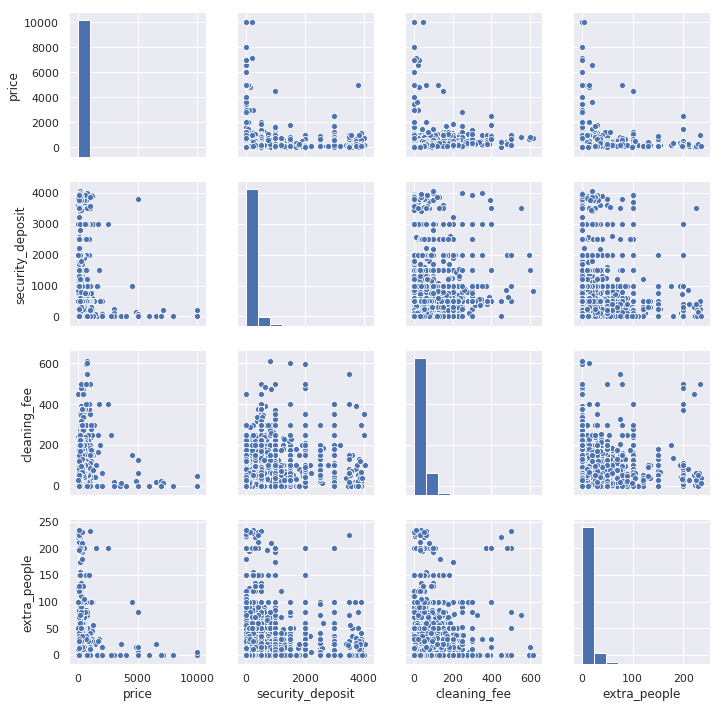

In [42]:
sns.pairplot(tmp_money_df)

In [43]:
high_price, high_deposit, high_cleaning_fee, high_extra_people = 1000,2000,200,100

high_price_count = (tmp_money_df.price >= high_price).sum()
high_deposit_count = (tmp_money_df.security_deposit >= high_deposit).sum()
high_cleaning_fee_count = (tmp_money_df.cleaning_fee >= high_cleaning_fee).sum()
high_extra_people_count = (tmp_money_df.extra_people >= high_extra_people).sum()

print('properties with very high price: {}'.format(high_price_count))
print('properties with very high security deposit: {}'.format(high_deposit_count))
print('properties with very high cleaning fee: {}'.format(high_cleaning_fee_count))
print('properties with very high extra people cost: {}'.format(high_extra_people_count))

properties with very high price: 123
properties with very high security deposit: 230
properties with very high cleaning fee: 332
properties with very high extra people cost: 199


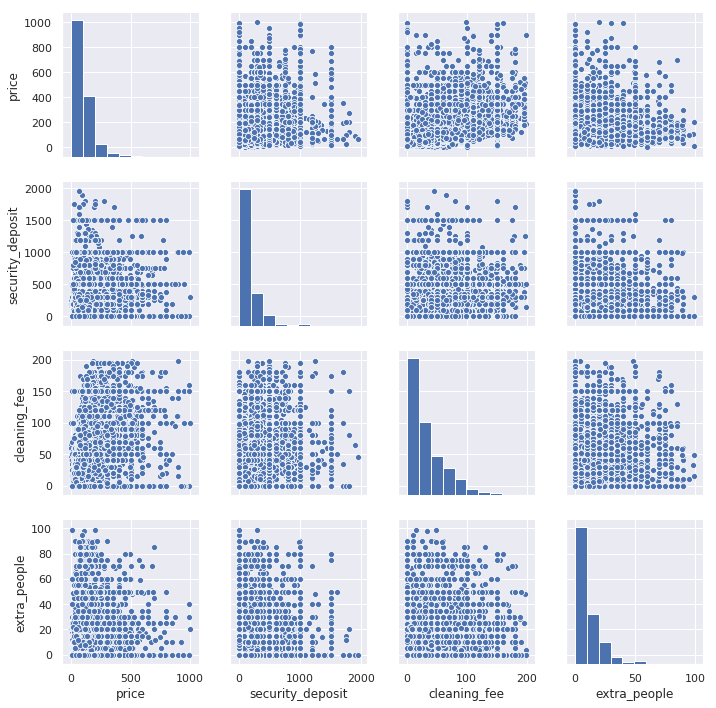

In [44]:
sns.pairplot(tmp_money_df[(tmp_money_df.price<high_price) & 
                          (tmp_money_df.security_deposit<high_deposit) & 
                          (tmp_money_df.cleaning_fee<high_cleaning_fee) & 
                          (tmp_money_df.extra_people<high_extra_people)])

There is no apparent correlation between price and "security deposit" or "extra people", good, moving on...

In [45]:
# We will now just concat and we will drop high values later one
df.drop(money_columns, axis=1, inplace=True)
df = pd.concat([df, tmp_money_df], axis=1)
df = df[(df.price<high_price) &
        (df.price!=0) &
        (df.security_deposit<high_deposit) &
        (df.cleaning_fee<high_cleaning_fee) &
        (df.extra_people<high_extra_people)]
print(df.shape)

(57739, 225)


In [46]:
# let's make sure there are no nan left
has_nan = df.isnull().any(axis=0)
has_nan = [df.columns[i] for i in np.where(has_nan)[0]]
if not has_nan: print('no NaN, all OK')

no NaN, all OK


## Computing a *"proxi"* for yield

Yield is defined as:

$$
yield = price * occupancy \: rate
$$

Occupancy rate can be calculated as:

$$
occupancy \: rate = (reviews\: / review \: rate) * average\: length\: of\: stay
$$

*review rate* and *average length of stay* are normally taken as a constant based in some model. For example, in the [San Francisco](http://insideairbnb.com/about.html) model a review rate of 0.5 is used to convert reviews to estimated bookings (i.e. we assume that only half of the guests will leave a review). An average length of stay of 3 nights  multiplied by the estimated bookings over a period gives the occupancy rate. Therefore, in the expression I have used below, if you want to turn my implementation of 'yield' into a "proper" one under the San Francisco model assumptions simply multiply my yield by 6 (3 * (1/0.5)) or by 72 (3 * 2 * 12) if you prefer per year.

In [49]:
df['yield'] = (df['price']+df['cleaning_fee']) * (df['reviews_per_month'])
df.drop(['price','cleaning_fee','reviews_per_month'], axis=1, inplace=True)

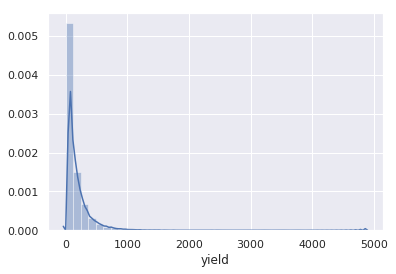

In [64]:
sns.distplot(df['yield'], bins=40)

In [73]:
np.percentile(df['yield'], 97)

612.0

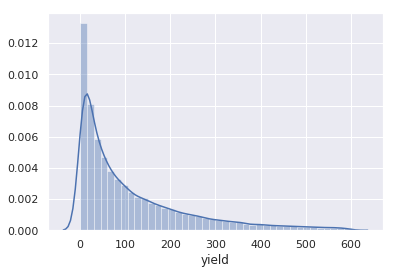

In [68]:
sns.distplot(df[df['yield']<=600]['yield'], bins=40)